In [1]:
!pip install --quiet mesa

# Basic Mesa Setup

In [2]:
import numpy as np
import math

from plotnine import * 
import pandas as pd

from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

# Agents

## Environment

The cells of the environment can hold and disperse pheromone. The are updated simultaneously.

In [3]:
class Environment(Agent):
    """
    A cell representing the Environment that will hold the chemical being
    disbursed, and then reduce that amount through diffusion and evaporation.
    """

    def __init__(self, unique_id, pos, model):
        """
        Create a new cell.
        Args:
            unique_id: a unique value to distinguish the agent
            pos: The cell's coordinates on the grid.
            model: standard model reference for agent.
        """
        super().__init__(unique_id, model)
        self.amount = 0.0

    def step(self):
        """
        Find the sum of chemical in the neighboring environment, including this
        cell, then set this cell to be the diffused and evaporated amount.
        """
        all_p = self.amount
        neighbors = [n for n in self.model.grid.get_neighbors(self.pos, True) if type(n) is Environment]
        for n in neighbors:
            all_p += n.amount
        ave_p = all_p / (len(neighbors) + 1)

        self._nextAmount = (1 - self.model.evaporate) * \
            (self.amount + (self.model.diffusion * \
                                (ave_p - self.amount)))

        if self._nextAmount < self.model.lowerbound:
            self._nextAmount = 0

    def advance(self):
        """
        Set the state to the new computed state -- computed in step().
        """
        self.amount = self._nextAmount

    def add(self, amount):
        """
        Add the amount to the cell's amount
        """
        self.amount += amount

    def get_pos(self):
        return self.pos

## Home

The home agent is where the ants start and where they return when they have found food.

In [4]:
class Home(Agent):
    """
    The home of the ants, recording how much food has been harvested.
    """
    def __init__(self, unique_id, pos, model):
        """
        Records the unique_id with the super, and saves the pos.
        Initializes the food amount to 0.
        """
        super().__init__(unique_id, model)
        #self.pos = pos
        self.amount = 0

    def add(self, amount):
        """
        Add the amount to the home amount
        """
        self.amount += amount

## Food

Food centers are in the world at certain locations, and dispense one piece of food for ants.

In [5]:
class Food(Agent):
    """
    A food cache for the ants, recording how much food is available.
    """
    def __init__(self, unique_id, model):
        """
        Records the unique_id with the super.
        Initializes the food amount to 0.
        """
        super().__init__(unique_id, model)
        self.amount = 0

    def add(self, amount):
        """
        Add the amount to the food amount
        """
        self.amount += amount

    def eaten(self):
        """
        Removes one food if there are any available
        """
        if self.any_food():
            self.amount -= 1

    def any_food(self):
        """
        Returns a bool to show if there is food available
        """
        return self.amount > 0

## Ants

Ants are the only agent that moves in this model. It searches the environment gradient for the highest pheromone, picks up food when at a food center, and returns home with food, dropping new pheromone on the way.

In [6]:
# from sugarscape_cg
def get_distance(pos_1, pos_2):
    """ Get the distance between two point

    Args:
        pos_1, pos_2: Coordinate tuples for both points.

    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx ** 2 + dy ** 2)

class Ant(Agent):
    """
    The ants wander around the world in search of food. Upon finding food,
    they drop a pheremone trail while heading home to store the food. When
    wandering, they either follow the strongest gradient of pheremone, or move randomly.
    """
    def __init__(self, unique_id, home, model, moore=True):
        super().__init__(unique_id, model)
        #self.pos = home.pos
        self.state = "FORAGING"
        self.drop = 0
        self.home = home
        self.moore = moore

    # derived from Sugarscape get_sugar()
    def get_item(self, item):
        """
        Finds the Agent of type item at this location in the Grid
        """
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        for agent in this_cell:
            if type(agent) is item:
                return agent

    def step(self):
        """
        Ants will either be FORAGING for food or HOMING in on the home location.
        If a FORAGING ant finds food, they eat it and begin HOMING, otherwise they
        wander either randomly or following the pheromone gradient.
        If a HOMING agent is home, they deposit their food and return FORAGING,
        otherwise they drop pheromone and take one step closer to home.
        """
        if self.state == "FORAGING":
            # Look for Food
            food = self.get_item(Food)

            if food is not None and food.any_food(): # Eat the food and then head home
                food.eaten()
                self.state = "HOMING"
                self.drop = self.model.initdrop

            else: # Not on food, move (up gradient or wander)
                if self.random.random() < self.model.prob_random:
                    self.random_move()
                else:
                    self.gradient_move()


        else: #HOMING
            # If Home, then go back to FORAGING
            if self.pos == self.home.pos:
                home = self.get_item(Home)
                home.add(1)
                self.state = "FORAGING"
                self.drop = 0
            else: #drop pheremone, and move toward home
                self.drop_pheromone()
                self.home_move()

    def drop_pheromone(self):
        """
        Leave pheromone in the Environment and reduce the pheromone drop
        """
        env = self.get_item(Environment)
        env.add(self.drop)
        self.drop *= self.model.drop_rate

    # from wolf_sheep RandomWalker
    def random_move(self):
        """
        Step one cell in any allowable direction.
        """
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

    # adapted from Sugarscape
    def home_move(self):
        """
        Step one cell toward self.home.pos.
        """
        # Get neighborhood within vision
        neighbors = [n.get_pos() for n in self.model.grid.get_neighbors(self.pos, self.moore) if type(n) is Environment]

        # Narrow down to the nearest ones to home
        min_dist = min([get_distance(self.home.pos, pos) for pos in neighbors])
        final_candidates = [
            pos for pos in neighbors if get_distance(self.home.pos, pos) == min_dist
        ]
        self.random.shuffle(final_candidates)
        self.model.grid.move_agent(self, final_candidates[0])

    def gradient_move(self):
        """
        Step one cell to the pheromone gradient in the Environment
        """
        # Find the neighbor Environment cell that has the highest pheromone amount
        where = (0, 0)
        maxp = self.model.lowerbound
        neighbors = [n for n in self.model.grid.get_neighbors(self.pos, self.moore) if type(n) is Environment]
        for n in neighbors:
            if n.amount > maxp:
                maxp = n.amount
                where = n.get_pos()

        # When something looks interesting, move there, otherwise randomly move
        if maxp > self.model.lowerbound:
            self.model.grid.move_agent(self, where)
        else:
            self.random_move()


# Model

The AntWorld creates all of the agents and collects data about the food levels of each center and the home space.

In [7]:
# derived from ConwaysGameOfLife
class AntWorld(Model):
    """
    Represents the ants foraging for food.
    """

    def __init__(self, height=50, width=50, evaporate=0.5, diffusion=1, initdrop=100, lowerbound=0.01, prob_random=0.1, drop_rate=0.9):
        """
        Create a new playing area of (height, width) cells.
        """

        super().__init__()
        self.evaporate = evaporate
        self.diffusion = diffusion
        self.initdrop = initdrop
        self.lowerbound = lowerbound
        self.prob_random = prob_random
        self.drop_rate = drop_rate

        # Set up the grid and schedule.

        # Use SimultaneousActivation which simulates all the cells
        # computing their next state simultaneously.  This needs to
        # be done because each cell's next state depends on the current
        # state of all its neighbors -- before they've changed.
        self.schedule = SimultaneousActivation(self)

        # Use a simple grid, where edges wrap around.
        self.grid = MultiGrid(height, width, torus=True)
        
        # Define pos for the initial home and food locations
        homeloc = (25, 25)
        food_locs = ((22, 11), (35, 8), (18, 33))

        self.home = Home(self.next_id(), homeloc, self)
        self.foods = []
        self.grid.place_agent(self.home, homeloc)
        self.schedule.add(self.home)

        # Add in the ants
        # Need to do this first, or it won't affect the cells, consequence of SimultaneousActivation
        for i in range(100):
            ant = Ant(self.next_id(), self.home, self)
            self.grid.place_agent(ant, self.home.pos)
            self.schedule.add(ant)

        # Add the food locations
        for loc in food_locs:
            food = Food(self.next_id(), self)
            food.add(100)
            self.foods.append(food)
            self.grid.place_agent(food, loc)
            self.schedule.add(food)

        # Place an environment cell at each location
        for contents, (x, y) in self.grid.coord_iter():
            cell = Environment(self.next_id(), (x, y), self)
            self.grid.place_agent(cell, (x, y))
            self.schedule.add(cell)

        self.running = True
        
        # Recording of the data
        self.dc = DataCollector({"Home": lambda m: self.home.amount,
                        "Loc 1": lambda m: self.foods[0].amount,
                        "Loc 2": lambda m: self.foods[1].amount,
                        "Loc 3": lambda m: self.foods[2].amount
                        })

    def step(self):
        """
        Have the scheduler advance each cell by one step
        """
        self.schedule.step()
        self.dc.collect(self)


        # stop when all the food is collected
        if self.home.amount == 300 or self.schedule.time > 1000:
            self.running = False

# Running the Model

Here we create the model and run the simulation for 1000 timesteps at most. We gather the data from the collector into a pandas DataFrame for easy visualization with plotnine.

In [8]:
ants = AntWorld()
ants.run_model()
results = ants.dc.get_model_vars_dataframe()

In [9]:
results

,Home,Loc 1,Loc 2,Loc 3
0,0,100,100,100
1,0,100,100,100
2,0,100,100,100
3,0,100,100,100
4,0,100,100,100
...,...,...,...,...
996,74,82,89,55
997,74,82,89,55
998,74,82,89,55
999,74,82,89,55


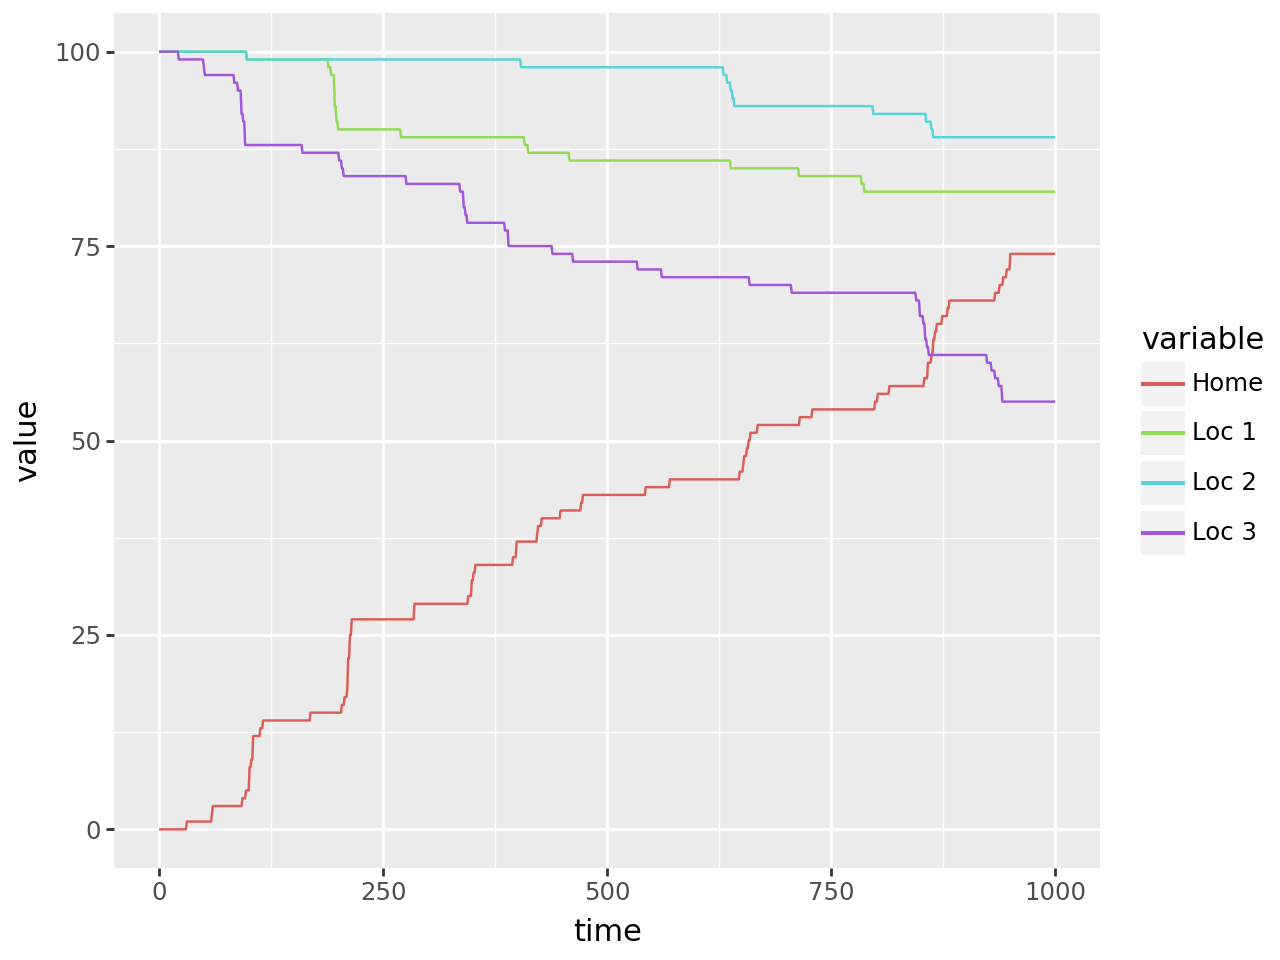

In [10]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Home","Loc 1","Loc 2","Loc 3"])

(
    ggplot(resultsmelt, aes(x="time", y="value", color="variable"))
    + geom_line()
)